In [1]:
import numpy as np 
import pandas as pd
import h5py as h5
import seaborn as sns
import tensorflow as tf
import sys

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import pickle
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.auto import tqdm

In [2]:
import tensorflow_addons as tfa

/home/tmadula/.conda/envs/UKAEA/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# do we have a gpu 
gpu = torch.cuda.is_available()

if gpu:
    device = torch.cuda.current_device()
    print(f'GPU device: {device}')
else: 
    print('No GPU')


GPU device: 0


## Data Prep

In [4]:
train_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl")
validation_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/valid_data_clipped.pkl")

In [5]:
keep_keys = ['ane', 'ate', 'autor', 'zeff', 'gammae', 
              'q', 'smag', 'alpha', 'ani1', 'ati0', 'ti_te0', 'x', 'normni1', 'machtor', 'lognustar', 'efiitg_gb']

In [6]:
train_data = train_data[keep_keys]
validation_data = validation_data[keep_keys]

nt, nv = train_data.shape[0], validation_data.shape[0]
nt_nan, nv_nan =  train_data['efiitg_gb'].isna().sum(), validation_data['efiitg_gb'].isna().sum()

train_data = train_data.dropna()
validation_data = validation_data.dropna()

assert train_data.shape[0] + nt_nan == nt
assert validation_data.shape[0] + nv_nan == nv

train_data['efiitg_gb'].loc[train_data['efiitg_gb'] != 0] = 1

validation_data['efiitg_gb'].loc[validation_data['efiitg_gb'] != 0] = 1

assert len(train_data['efiitg_gb'].unique()) == 2
assert len(validation_data['efiitg_gb'].unique()) == 2

In [7]:
x_train, y_train = train_data.iloc[:,:-1].to_numpy(), train_data.iloc[:,-1].to_numpy()
x_val, y_val = validation_data.iloc[:,:-1].to_numpy(), validation_data.iloc[:,-1].to_numpy()

In [8]:
# standard scaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform (x_val)

### Dealing with Class imbalance

To deal with our class imbalance we will add sample weights to each class using the inverse number of samples

In [9]:
def get_weights(num_of_classes: int, samples_per_class: np.ndarray, power: int =1): 
    weights_for_samples = 1/samples_per_class
    weights_for_samples = weights_for_samples/np.sum(weights_for_samples)*num_of_classes
    return weights_for_samples

## Classifier (tensorflow implementation)

In [ ]:
def nn_classifier():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation = 'sigmoid')   
    ])
    return model

In [13]:
model = tf.keras.models.load_model("saved_model/itg_classifier")

2022-03-11 15:48:48.737569: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-11 15:48:48.738045: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 15:48:48.738151: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [15]:
test_data = pd.read_pickle("/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl")

In [16]:
test_data = test_data[keep_keys]

nt = test_data.shape[0]
nt_nan =  test_data['efiitg_gb'].isna().sum()

test_data = test_data.dropna()

assert test_data.shape[0] + nt_nan == nt

test_data['efiitg_gb'].loc[test_data['efiitg_gb'] != 0] = 1

assert len(test_data['efiitg_gb'].unique()) == 2

In [17]:
x_test, y_test = test_data.iloc[:,:-1].to_numpy(), test_data.iloc[:,-1].to_numpy()

In [18]:
x_test = scaler.transform(x_test)

In [19]:
predictions = model.predict(x_test)

fpr, tpr, thresholds = roc_curve(y_test, predictions)

2022-03-11 15:49:23.093102: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-11 15:49:23.093917: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


In [20]:
auc = roc_auc_score(y_test, predictions)

Text(0.8, 0.2, 'auc =  1.00')

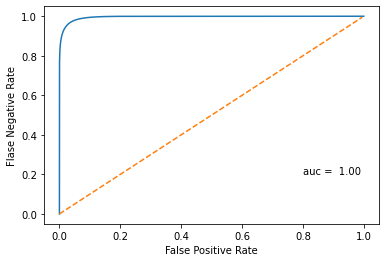

In [21]:
plt.figure()
plt.plot(fpr, tpr)
random_class = np.arange(0,1,0.005)
plt.plot(random_class, random_class, '--')
plt.xlabel('False Positive Rate')
plt.ylabel('Flase Negative Rate')
plt.text(0.8, 0.2, f'auc = {auc: .2f}', fontsize=10)

In [22]:
test_pred = np.where(predictions < 0.5, predictions, 1)
test_pred = np.where(predictions >= 0.5, test_pred, 0)

n_positive = np.where(y_test ==0)[0].shape[0]
n_negative = np.where(y_test ==1)[0].shape[0]
div_arr = np.array([[n_positive, n_negative]]).T

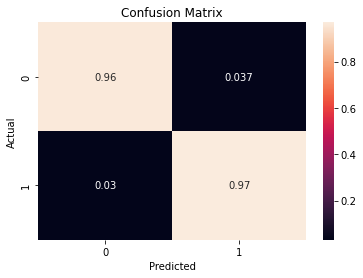

In [23]:
con_mat = confusion_matrix(y_test, test_pred, labels =[0,1])/div_arr
sns.heatmap(con_mat, annot=True).set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

In [24]:
val_indices = np.random.choice(x_val.shape[0], size = 100_000, replace=False)
x_val_sample = x_val[val_indices]
y_val_sample = y_val[val_indices]

In [25]:
data_dict = pickle.load(open("/home/tmadula/submit/outputs/itg_outputs.pkl", 'rb'))

In [26]:
data_dict.keys()

dict_keys(['training_size', 'train_losses', 'val_losses', 'train_f1', 'val_f1'])

In [29]:
training_size = data_dict['training_size']
val_losses = data_dict['val_losses']
val_f1 = data_dict['val_f1']

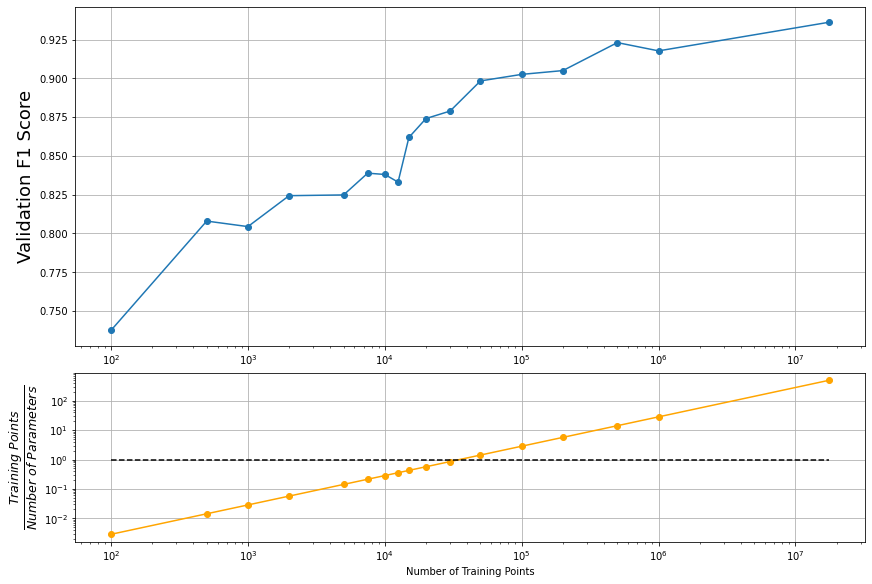

In [30]:
loss_ = [x[-1] for x in val_losses]
f1_ = [x[-1] for x in val_f1]

trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
ratio = training_size / trainable_params


mosaic = """
    A
    A
    B
"""

fig = plt.figure(constrained_layout= True, figsize = (12,8))

ax_dict = fig.subplot_mosaic(mosaic)

ax_dict["A"].plot(training_size, f1_, "-o")
ax_dict["A"].set_xscale("log");
ax_dict["A"].set_ylabel("Validation F1 Score", size = 18);
ax_dict["A"].grid()

ax_dict["B"].plot(training_size, ratio, "-o", color = "orange")
ax_dict["B"].set_xscale("log");
ax_dict["B"].set_yscale("log");
ax_dict["B"].hlines(1, training_size[0], training_size[-1], linestyles = "dashed", color = "k")
ax_dict["B"].grid()
ax_dict["B"].set_ylabel(r"$\frac{Training\ Points}{Number\ of\ Parameters}$", size = 18);

plt.xlabel("Number of Training Points");



In [31]:
import shap
from scripts.utils import train_keys

In [32]:
x_train_df = pd.DataFrame(x_train, columns = train_keys)
x_val_df = pd.DataFrame(x_val, columns = train_keys)

In [33]:
f = lambda x: model.predict(x)
med = np.median(x_train, axis = 0).reshape((1,x_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(x_val_df.iloc[:1000])

Permutation explainer: 1001it [11:21,  1.46it/s]                          


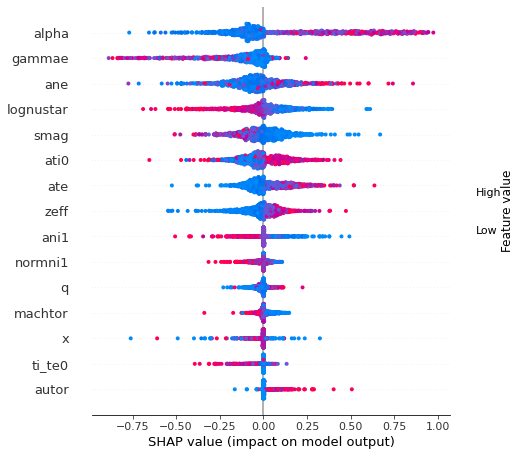

In [34]:
shap.plots.beeswarm(shap_values, max_display = 20)